#Step 1: Imports

In [ ]:
# Core libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows',None)

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.4)
import plotly.express as px

# Still don't know but looks useful
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#Step 2: Data

####Load Data

In [ ]:
data = pd.read_csv('credit_risk_customer_data.csv')

# Preview of dataset
print('Shape of dataframe:', data.shape)
data.head()

Shape of dataframe: (1125, 13)


,label,id,fea_1,fea_2,fea_3,fea_4,fea_5,fea_6,fea_7,fea_8,fea_9,fea_10,fea_11
0,1,54982665,5,1245.5,3,77000.0,2,15,5,109,5,151300,244.948974
1,0,59004779,4,1277.0,1,113000.0,2,8,-1,100,3,341759,207.173840
2,0,58990862,7,1298.0,1,110000.0,2,11,-1,101,5,72001,1.000000
3,1,58995168,7,1335.5,1,151000.0,2,11,5,110,3,60084,1.000000
4,0,54987320,7,NaN,2,59000.0,2,11,5,108,4,450081,197.403141


####Available Columns

In [ ]:
data.columns

Index(['label', 'id', 'fea_1', 'fea_2', 'fea_3', 'fea_4', 'fea_5', 'fea_6',
       'fea_7', 'fea_8', 'fea_9', 'fea_10', 'fea_11'],
      dtype='object')

####Checking for Missing Values

In [ ]:
print('MISSING VALUES')
print(data.isna().sum())

MISSING VALUES
label       0
id          0
fea_1       0
fea_2     149
fea_3       0
fea_4       0
fea_5       0
fea_6       0
fea_7       0
fea_8       0
fea_9       0
fea_10      0
fea_11      0
dtype: int64


####Checking for Duplicates

In [ ]:
print(f'Duplicates in train set: {data.duplicated().sum()}')

Duplicates in train set: 0


####Cardinality of Features

In [ ]:
data.nunique()

label        2
id        1125
fea_1        6
fea_2      158
fea_3        3
fea_4      229
fea_5        2
fea_6       10
fea_7       10
fea_8       52
fea_9        5
fea_10     280
fea_11     266
dtype: int64

label: Target column <br>
id: Descriptive <br>
fea_1: Categorical<br>
fea_2: Continuous<br>
fea_3: Categorical<br>
fea_4: Continuous<br>
fea_5: Categorical<br>
fea_6: Categorical<br>
fea_7: Categorical<br>
fea_8: Continuous<br>
fea_9: Categorical<br>
fea_10: Continuous<br>
fea_11: Continuous<br>


In [ ]:
cont_feat = ['fea_2', 'fea_4', 'fea_8', 'fea_10', 'fea_11']
cat_feat = ['fea_1', 'fea_3', 'fea_5', 'fea_6', 'fea_7', 'fea_9']

####Data Types of Features

In [ ]:
data.dtypes

label       int64
id          int64
fea_1       int64
fea_2     float64
fea_3       int64
fea_4     float64
fea_5       int64
fea_6       int64
fea_7       int64
fea_8       int64
fea_9       int64
fea_10      int64
fea_11    float64
dtype: object

#Step 3: Exploratory Data Analysis

####Checking for Target Distribution

0    900
1    225
Name: label, dtype: int64

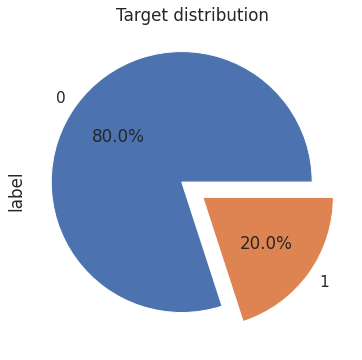

In [ ]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
data['label'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%').set_title("Target distribution")

count_category = data.label.value_counts(dropna=False,)
count_category

####Balancing the Target Distribution

In [ ]:
def sampling_k_elements(f, k=225):
    if len(f) < k:
        return f
    return f.sample(k)

balanced = data.groupby('label').apply(sampling_k_elements).reset_index(drop=True)

In [ ]:
count_balanced = balanced.label.value_counts(dropna=False,)
count_balanced

0    225
1    225
Name: label, dtype: int64

In [ ]:
balanced.shape

(450, 13)

Text(0.5, 1.0, 'Target distribution')

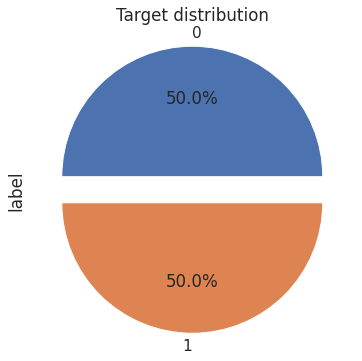

In [ ]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
balanced['label'].value_counts().plot.pie(explode=[0.1,0.1], autopct='%1.1f%%').set_title("Target distribution")

####Exploring Continuous Features

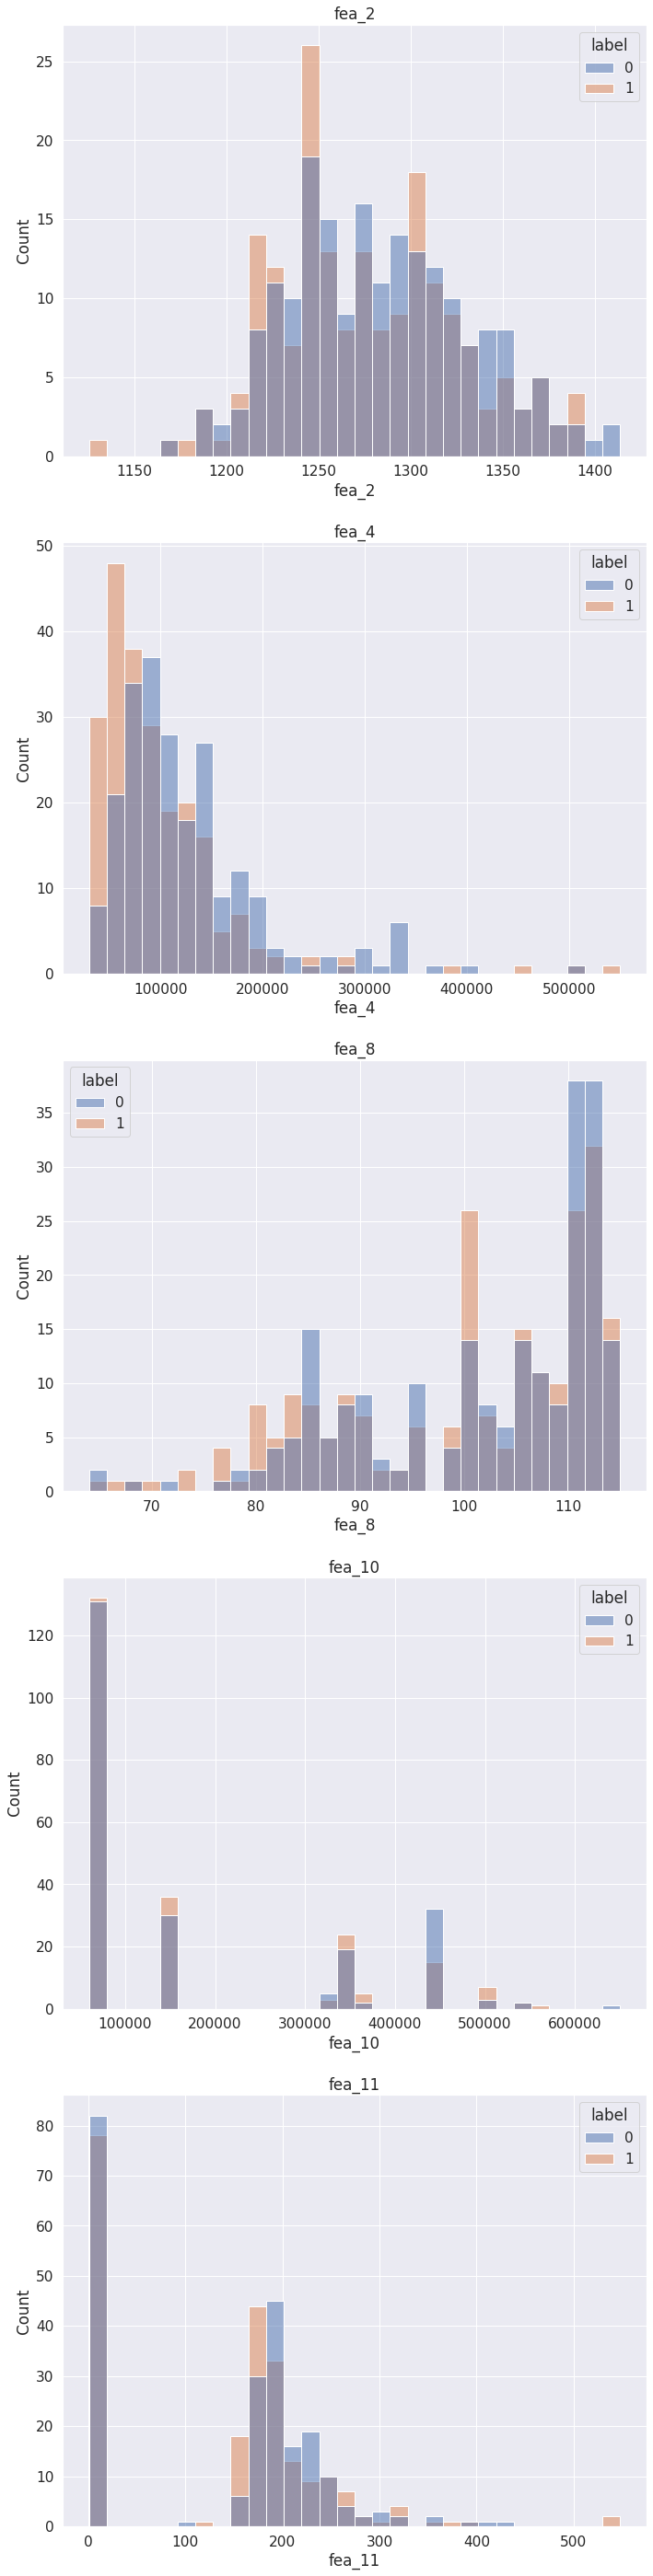

In [ ]:
fig=plt.figure(figsize=(25, 50))
for i, var_name in enumerate(cont_feat):
    ax=fig.add_subplot(len(cont_feat),2,2*i+1)
    sns.histplot(data=balanced, x=var_name, axes=ax, bins=30, kde=False, hue='label')
    ax.set_title(var_name)

**Notes**:


*  `fea_2` : 1265>=x is most probably 1 and 1265<x is most probably 0
*  `fea_4` : 75000>=x is most probably 1 and 75000<x is most probably 
*  `fea_8` : looks evenly distributed
*  `fea_10` : 300000>=x and x>=400000 most probably 0 and 300000<x and x<400000 most probably 1
*  `fea_11` : 0 is most probably 0 and not 0 is most probably 1

**Insights**:

*  Create a new feature based on `fea_2` which is `less_1265`
*  Create a new feature based on `fea_4` which is `less_75000`
*  Drop `fea_8`
*  Create a new feature based on `fea_10` which is `between_3n4`
*  Create a new feature based on `fea_11` which is `not_0`
*  Take Log Transform to reduce skew 




####Exploring Categorical Values

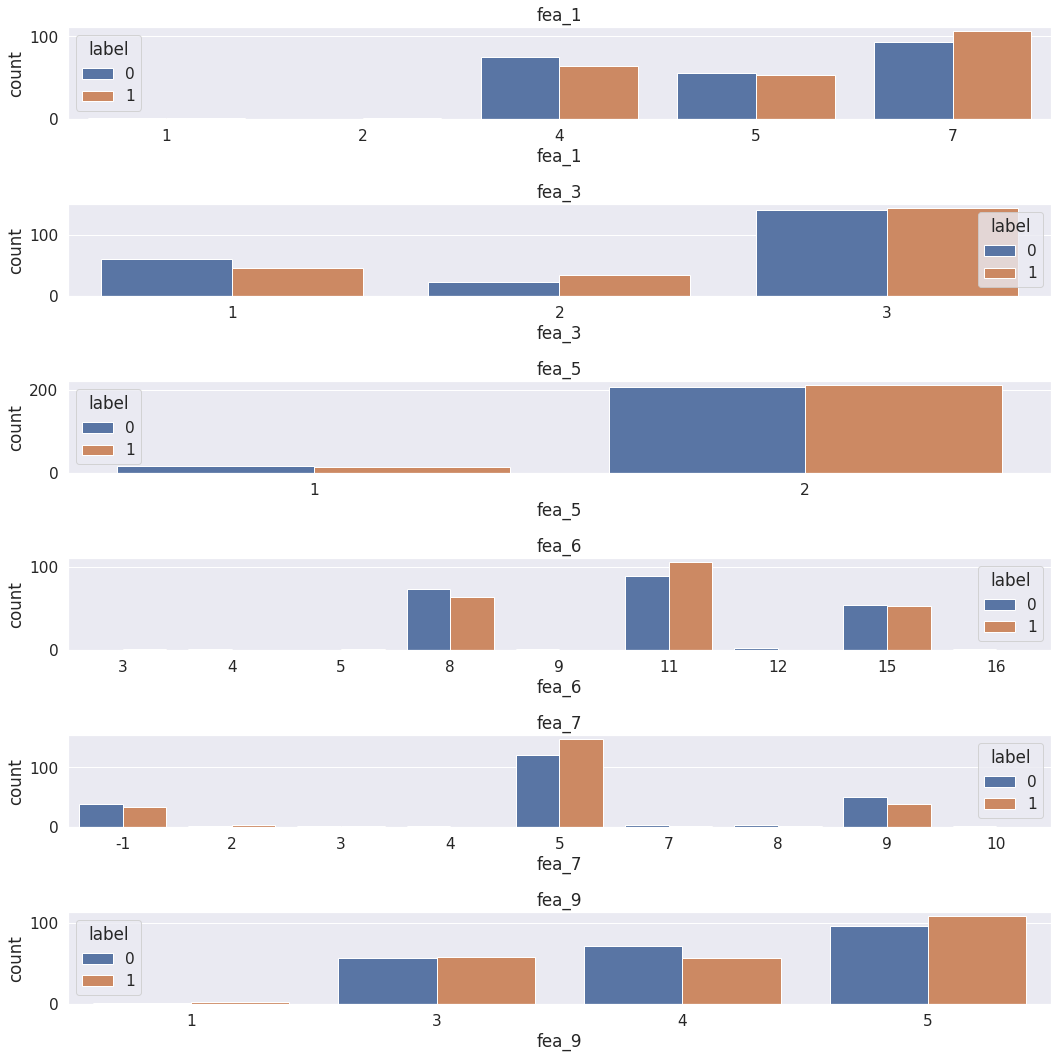

In [ ]:
# Plot categorical features
fig=plt.figure(figsize=(15,15))
for i, var_name in enumerate(cat_feat):
    ax=fig.add_subplot(len(cat_feat),1,i+1)
    sns.countplot(data=balanced, x=var_name, axes=ax, hue='label')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

**Notes**:
*  `fea_1` : 5 and 7 is most probably 1; 4 is most probably 0; 1, 2, and 6 is evenly distributed
*  `fea_3` : 1 is most probably 0; 2 is most probably 1;3 is evenly distributed
*  `fea_5` : evenly distributed
*  `fea_6` : 11 and 15 is most probably 1; 4 and 8 is most probably 0; 3, 5, 6, 9, 12 is evenly distributed
*  `fea_7` : 4, 8, 9 is 0; 5 is 1; -1, 2, 3, 7 is evenly distributed
*  `fea_9` : evenly distributed

**Insights**:
*  Compress all values of all features into smaller groups except for the evenly distributed ones
*  Drop `fea_5` and `fea_9`

#Step 4: Feature Engineering

####fea_1
5 and 7 is most probably 1; 4 is most probably 0; 1, 2, and 6 is evenly distributed

In [ ]:
balanced.loc[balanced['fea_1']==4, 'fea_1'] = '0'
balanced.loc[balanced['fea_1']==5, 'fea_1'] = '1'
balanced.loc[balanced['fea_1']==7, 'fea_1'] = '1'
balanced.loc[balanced['fea_1']==1, 'fea_1'] = '2'
balanced.loc[balanced['fea_1']==2, 'fea_1'] = '2'
balanced.loc[balanced['fea_1']==6, 'fea_1'] = '2'
balanced['fea_1'] = balanced['fea_1'].astype(dtype=int)

####fea_2
1265>=x is most probably 1 and 1265<x is most probably 0

In [ ]:
balanced['less_1265'] = np.nan
balanced.loc[balanced['fea_2']<=1265, 'less_1265'] = 1
balanced.loc[balanced['fea_2']>1265, 'less_1265'] = 0

####fea_3
1 is most probably 0; 2 is most probably 1; 3 is evenly distributed

In [ ]:
balanced.loc[balanced['fea_3']==1, 'fea_3'] = '0'
balanced.loc[balanced['fea_3']==2, 'fea_3'] = '1'
balanced.loc[balanced['fea_3']==3, 'fea_3'] = '2'
balanced['fea_3'] = balanced['fea_3'].astype(dtype=int)

####fea_4
75000>=x is most probably 1 and 75000<x is most probably 

In [ ]:
balanced['less_75000'] = np.nan
balanced.loc[balanced['fea_4']<=75000, 'less_75000'] = 1
balanced.loc[balanced['fea_4']>75000, 'less_75000'] = 0

####fea_5
evenly distributed

In [ ]:
balanced.drop('fea_5', axis=1, inplace=True)

####fea_6
11 and 15 is most probably 1; 4 and 8 is most probably 0; 3, 5, 6, 9, 12 is evenly distributed

In [ ]:
balanced.loc[balanced['fea_6']==4, 'fea_6'] = '0'
balanced.loc[balanced['fea_6']==8, 'fea_6'] = '0'
balanced.loc[balanced['fea_6']==11, 'fea_6'] = '1'
balanced.loc[balanced['fea_6']==15, 'fea_6'] = '1'
balanced.loc[balanced['fea_6']==3, 'fea_6'] = '2'
balanced.loc[balanced['fea_6']==5, 'fea_6'] = '2'
balanced.loc[balanced['fea_6']==6, 'fea_6'] = '2'
balanced.loc[balanced['fea_6']==9, 'fea_6'] = '2'
balanced.loc[balanced['fea_6']==12, 'fea_6'] = '2'
balanced['fea_6'] = balanced['fea_6'].astype(dtype=int)

####fea_7
4, 8, 9 is 0; 5 is 1; -1, 2, 3, 7 is evenly distributed

In [ ]:
balanced.loc[balanced['fea_7']==4, 'fea_7'] = '0'
balanced.loc[balanced['fea_7']==8, 'fea_7'] = '0'
balanced.loc[balanced['fea_7']==9, 'fea_7'] = '0'
balanced.loc[balanced['fea_7']==5, 'fea_7'] = '1'
balanced.loc[balanced['fea_7']==-1, 'fea_7'] = '2'
balanced.loc[balanced['fea_7']==2, 'fea_7'] = '2'
balanced.loc[balanced['fea_7']==3, 'fea_7'] = '2'
balanced.loc[balanced['fea_7']==7, 'fea_7'] = '2'
balanced['fea_7'] = balanced['fea_7'].astype(dtype=int)

####fea_8
evenly distributed

In [ ]:
balanced.drop('fea_8', axis=1, inplace=True)

####fea_9
evenly distributed

In [ ]:
balanced.drop('fea_9', axis=1, inplace=True)

####fea_10
300000>=x and x>=400000 most probably 0 and 300000<x and x<400000 most probably 1

In [ ]:
balanced['between_3n4'] = np.nan
balanced.loc[(balanced['fea_10']>300000) & (balanced['fea_10']<400000), 'between_3n4'] = 1
balanced.loc[balanced['fea_10']<=300000, 'between_3n4'] = 0
balanced.loc[balanced['fea_10']>=400000, 'between_3n4'] = 0

####fea_11
0 is most probably 0 and not 0 is most probably 1

In [ ]:
balanced['not_0'] = np.nan
balanced.loc[balanced['fea_11']!=0, 'not_0'] = 1
balanced.loc[balanced['fea_11']==0, 'not_0'] = 0

In [ ]:
balanced.head()

,label,id,fea_1,fea_2,fea_3,fea_4,fea_6,fea_7,fea_10,fea_11,less_1265,less_75000,between_3n4,not_0
0,0,58997607,0,1268.0,0,118000.0,0,2,330006,1.000000,0.0,0.0,1.0,1.0
1,0,58985486,1,1298.0,2,149000.0,1,1,510069,222.551118,0.0,0.0,0.0,1.0
2,0,58992134,1,1235.0,0,114000.0,1,2,450088,1.000000,1.0,0.0,0.0,1.0
3,0,54988258,1,1320.5,0,119000.0,1,1,60043,212.132034,0.0,0.0,0.0,1.0
4,0,59003950,0,1263.5,0,102000.0,0,0,60024,200.000000,1.0,0.0,0.0,1.0


#Step 5: Missing Values

####Filling fea_2

Which columns are positively correlated to fea_2

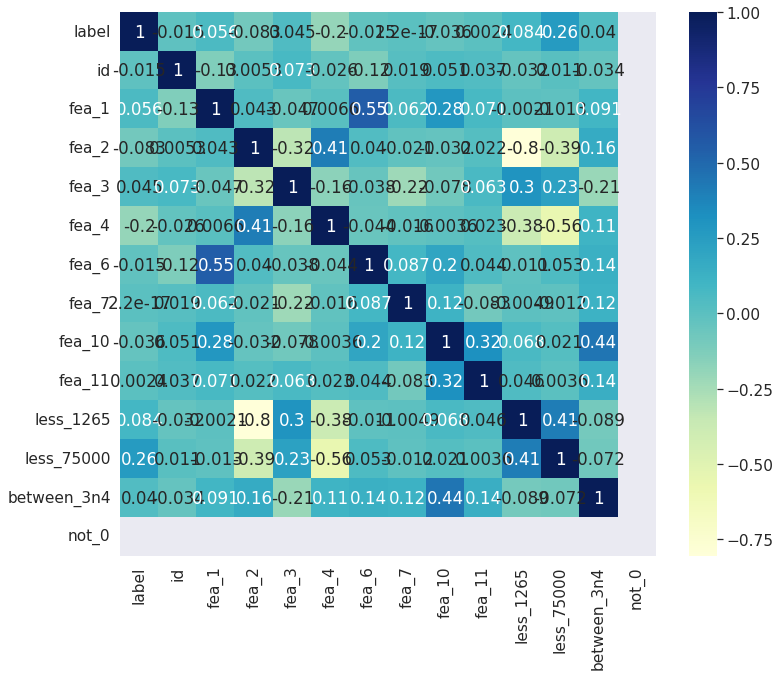

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(balanced.corr(), annot=True, cmap="YlGnBu")
plt.show()

In [ ]:
f2_pos = ['id', 'fea_1', 'fea_4', 'fea_6', 'fea_7', 'fea_10', 'fea_11', 'between_3n4']

####Splitting rows with missing values

In [ ]:
test_fill = balanced[balanced.isnull().any(axis=1)]
train_fill = balanced[~balanced.isnull().any(axis=1)]

In [ ]:
model_fill = LinearRegression()
y_fill = train_fill['fea_2']
X_fill = train_fill[f2_pos]
model_fill.fit(X_fill, y_fill)
test_fill['fea_2'] = model_fill.predict(test_fill[f2_pos])

#filling less_1265
test_fill.loc[test_fill['fea_2']<=1265, 'less_1265'] = 1
test_fill.loc[test_fill['fea_2']>1265, 'less_1265'] = 0

test_fill

,label,id,fea_1,fea_2,fea_3,fea_4,fea_6,fea_7,fea_10,fea_11,less_1265,less_75000,between_3n4,not_0
6,0,58994740,1,1256.179386,1,77000.0,1,0,510000,159.699718,1.0,0.0,0.0,1.0
9,0,58994019,1,1278.549464,2,156000.0,1,1,450069,165.831240,0.0,0.0,0.0,1.0
13,0,59000044,1,1267.306518,1,51000.0,1,1,72015,170.293864,0.0,1.0,0.0,1.0
14,0,59003535,0,1283.039898,1,139000.0,0,1,60036,1.000000,0.0,0.0,0.0,1.0
20,0,54984616,1,1288.687833,1,102000.0,1,1,350055,184.390889,0.0,0.0,1.0,1.0
28,0,59004748,0,1274.689441,1,105000.0,0,1,60014,187.082869,0.0,0.0,0.0,1.0
40,0,58991252,1,1264.977330,2,108000.0,1,2,450006,158.113883,1.0,0.0,0.0,1.0
42,0,58985785,1,1302.311767,2,250000.0,1,2,450031,187.082869,0.0,0.0,0.0,1.0
52,0,54988000,1,1296.046038,1,180000.0,1,1,72001,167.332005,0.0,0.0,0.0,1.0
80,0,58995669,1,1241.932693,2,35000.0,2,2,650070,161.854873,1.0,1.0,0.0,1.0


####Recombining

In [ ]:
cleaned = pd.concat([train_fill, test_fill], axis=0).reset_index(drop=True)

####Rechecking for missing values

In [ ]:
print('MISSING VALUES AFTER:')
print(cleaned.isna().sum())
print()
print('Shape:')
cleaned.shape

MISSING VALUES AFTER:
label          0
id             0
fea_1          0
fea_2          0
fea_3          0
fea_4          0
fea_6          0
fea_7          0
fea_10         0
fea_11         0
less_1265      0
less_75000     0
between_3n4    0
not_0          0
dtype: int64

Shape:


(450, 14)

#Saving cleaned dataset

In [ ]:
cleaned.to_csv('credit_risk_customer_cleaned.csv')